# Imports

In [64]:
# Imports
import numpy as np
from numpy.random import choice
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

# Load Data

In [2]:
# Load dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# First rows of dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA Process

In [4]:
# Basic information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Descriptive statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Missing values
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [7]:
# Duplicated rows
train.duplicated().any()

False

## Handling Missing Values & Duplicated Rows

In [8]:
# Distrubution for the non-numeric features
def take_dist(data: pd.DataFrame):
    return data.value_counts(normalize=True)

In [9]:
# Drop the 'cabin' row --> channel has too much missing values
train = train.drop('Cabin', axis=1)

In [10]:
# Assign the mean age value to the missing age
train.loc[train['Age'].isna(), 'Age'] = train['Age'].mean()

In [11]:
# Changing missing categorical features with weighted average equivalent
train.loc[train['Embarked'].isna(), 'Embarked'] = choice(take_dist(train['Embarked']).index, p=take_dist(train['Embarked']).values)

In [12]:
# Check the missing values again
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool

## Handling Outliers

<Axes: title={'center': 'Age Boxplot'}, xlabel='Age'>

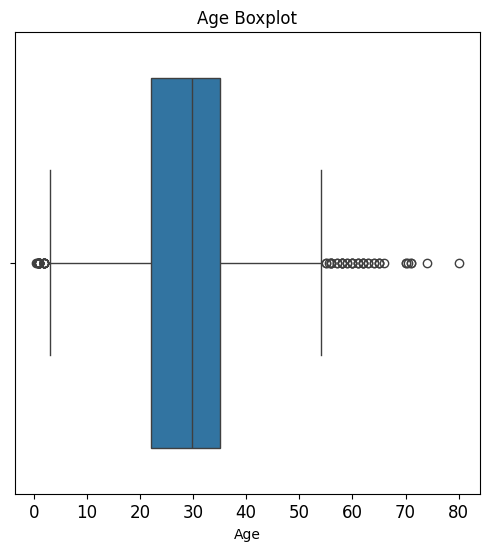

In [13]:
# Check outliers for age
plt.figure(figsize=(6, 6))
plt.title('Age Boxplot', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=train['Age'])

In [14]:
# Clean the outliers from the age
percentile_25 = train['Age'].quantile(0.25)
percentile_75 = train['Age'].quantile(0.75)
iqr = percentile_75 - percentile_25
upper_limit = percentile_75 + 1.5 * iqr
lower_limit = percentile_25 - 1.5 * iqr

print(f'Lower Limit: {lower_limit}')
print(f'Upper Limit: {upper_limit}')

outlier_mask = (train['Age'] > upper_limit) | (train['Age'] < lower_limit )
outliers = train['Age'][outlier_mask]
print(f'Number of outliers in age: {len(outliers)}')


Lower Limit: 2.5
Upper Limit: 54.5
Number of outliers in age: 66


In [15]:
# Number of passengers survived vs. died
print(train['Survived'].value_counts())

# Percentage of people who survived vs. died
print(train['Survived'].value_counts(normalize=True))

Survived
0    549
1    342
Name: count, dtype: int64
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [16]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

## Data Visualization & Feature Engineering

- Visualize data to get descriptive analysis for decision making
- Map selected channels to group data

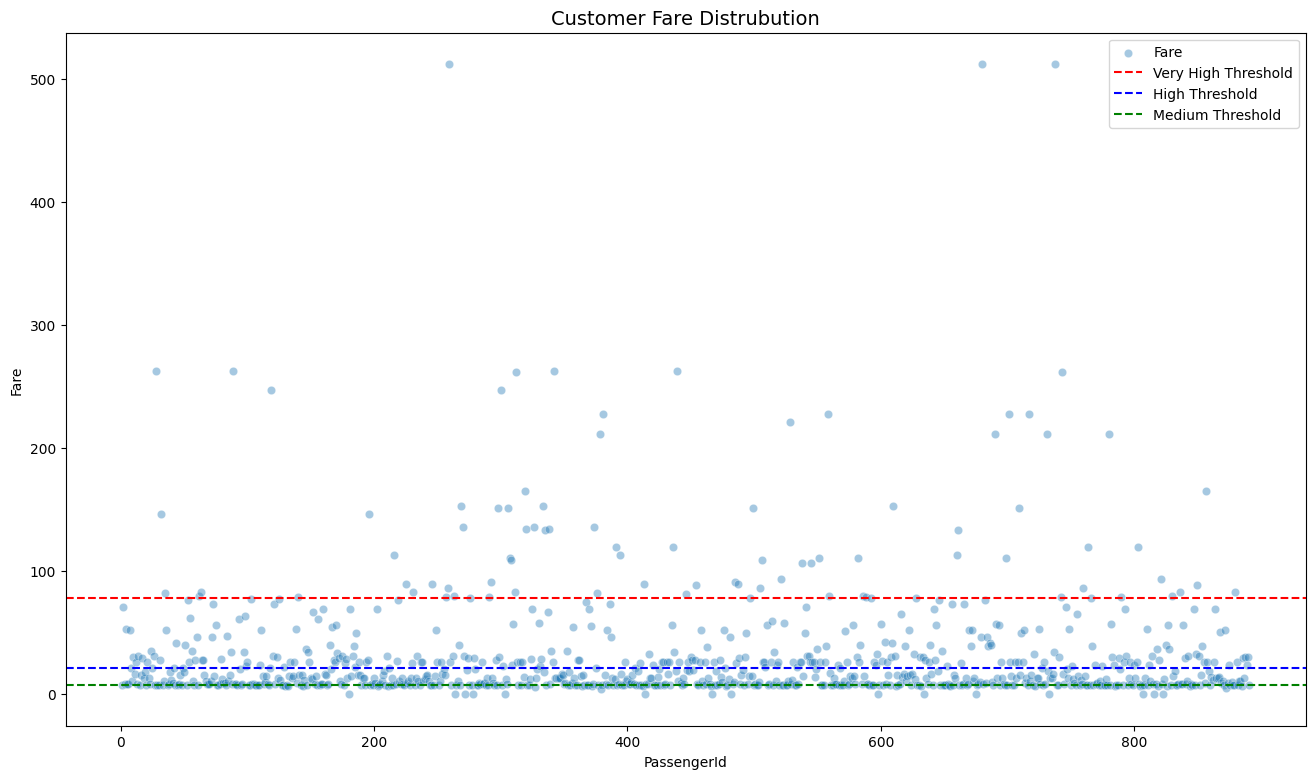

In [17]:
# Plot 'fare' distrubution before mapping the customer fare
plt.figure(figsize=(16, 9))
sns.scatterplot(data=train, x='PassengerId', y='Fare', alpha=0.4)
plt.axhline(y=train['Fare'].quantile(0.9), color='red', label='Very High Thresh.', ls='--')
plt.axhline(y=train['Fare'].quantile(0.6), color='blue', label='High Thresh.', ls='--')
plt.axhline(y=train['Fare'].quantile(0.2), color='green', label='Medium Thresh.', ls='--')
plt.legend(labels=['Fare', 'Very High Threshold', 'High Threshold', 'Medium Threshold'])
plt.title('Customer Fare Distrubution', fontsize='14');

In [18]:
# Grouping the 'Fare' according to the visualized thresholds
very_high_fare = train['Fare'].values >= train['Fare'].quantile(0.9)
high_fare = (train['Fare'].values >= train['Fare'].quantile(0.6)) & (train['Fare'].values < train['Fare'].quantile(0.9))
medium_fare = (train['Fare'].values >= train['Fare'].quantile(0.2)) & (train['Fare'].values < train['Fare'].quantile(0.6))
low_fare = train['Fare'].values < train['Fare'].quantile(0.2)
train['Fare_dist'] = np.where(very_high_fare, 3,
                               np.where(high_fare, 2,
                                        np.where(medium_fare, 1,
                                                np.where(low_fare, 0, np.nan))))

In [19]:
# Categorical Features to Numerical Features
train['Sex'] = np.where(train['Sex'] == 'male', 1,
                               np.where(train['Sex'] == 'female', 0, np.nan))

train['Embarked'] = np.where(train['Embarked'] == 'C', 0,
                               np.where(train['Embarked'] == 'Q', 1, 
                                        np.where(train['Embarked'] == 'S', 2, np.nan)))


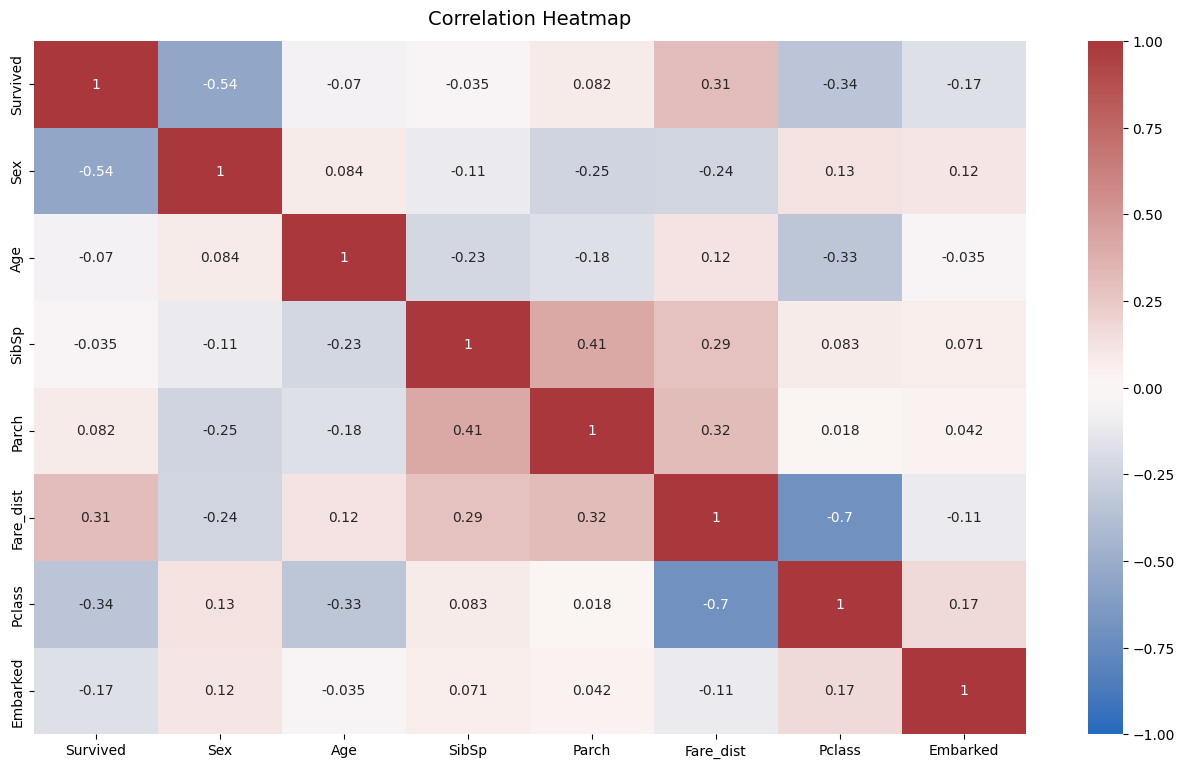

In [20]:
# Heatmap to see correlations between channels
df_heat = train[['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare_dist', 'Pclass', 'Embarked']]
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df_heat.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

# Selected features
- sex
- age	
- parch	
- fare dist
- embarked

In [21]:
train = train[['Survived', 'Sex', 'Age', 'Parch', 'Fare_dist']]

In [22]:
train.head()

,Survived,Sex,Age,Parch,Fare_dist
0,0,1.0,22.0,0,0.0
1,1,0.0,38.0,0,2.0
2,1,0.0,26.0,0,1.0
3,1,0.0,35.0,0,2.0
4,0,1.0,35.0,0,1.0


## Modeling
Construct several AI models to find out max. performed model on the data

### Logistic Regression

In [23]:
# Selecting the features
X = train.drop('Survived', axis=1)

In [24]:
# First 5 rows of the features
X.head()

,Sex,Age,Parch,Fare_dist
0,1.0,22.0,0,0.0
1,0.0,38.0,0,2.0
2,0.0,26.0,0,1.0
3,0.0,35.0,0,2.0
4,1.0,35.0,0,1.0


In [25]:
# Isolating the result variable
y = train['Survived']

In [26]:
# First 5 rows of the result
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [142]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=700).fit(X_train, y_train)

In [143]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

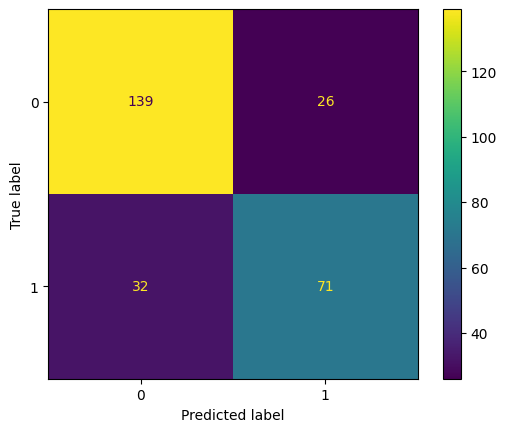

In [144]:
# Confusion matrix for visualize results
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [145]:
# Create classification report for logistic regression model
target_names = ['Predicted would not survive', 'Predicted would survive']
print(classification_report(y_test, y_pred, target_names=target_names))

                             precision    recall  f1-score   support

Predicted would not survive       0.81      0.84      0.83       165
    Predicted would survive       0.73      0.69      0.71       103

                   accuracy                           0.78       268
                  macro avg       0.77      0.77      0.77       268
               weighted avg       0.78      0.78      0.78       268



- Reports above show that model achieved 78% precision and has 78% f1 score. 
- We can increase the overall performance with trying other models on the data.

### Decision Tree

In [146]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[2, 3, 5, 8],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 3, 4]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [147]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 1.02 s
Wall time: 1 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 5, 8],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 4]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [148]:
# Check best parameters
tree1.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [149]:
# Check best AUC score on CV
tree1.best_score_

0.8273603019067797

In [150]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [151]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.744397,0.677048,0.708037,0.789578,0.82736


- Decision tree decreased the overall score.

### Random Forest

In [152]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3, 5, 7], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [200, 300, 400],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [153]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

CPU times: total: 3min 7s
Wall time: 3min 7s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, 7], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 300, 400]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [35]:
# Path to the folder where you want to save the model
path = 'models/'

In [32]:
# Model saving function
def write_pickle(path, model_object, save_as:str):  
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [33]:
# Model reading function
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

In [158]:
# Write pickle
write_pickle(path, rf1, 'hr_rf2')

In [159]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf2')

In [160]:
# Check best AUC score on CV
rf1.best_score_

0.8331931938559323

In [161]:
# Check best params
rf1.best_params_

{'max_depth': 3,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 300}

In [162]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.761287  0.719492  0.739703  0.805718  0.833193


### XGBoost

In [28]:
# Instantiate model
xgb = XGBClassifier()

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3, 4, 5], 
             'learning_rate': [0.1, 0.01, 0.001],
             'n_estimators': [100, 200, 300],
             'subsample': [0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
grid_search = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc', verbose=1)

In [30]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 243 candidates, totalling 972 fits


C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u29f98\Documents\data_science\venv\lib\site-packages

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [36]:
# Write pickle
write_pickle(path, grid_search, 'xgb_test')

In [37]:
# Read pickle
xgb_model_test = read_pickle(path, 'xgb_test')

In [38]:
# Check best AUC score on CV
xgb_model_test.best_score_

0.8463835922787195

In [39]:
# Check the best hyperparameters on XGB Model
xgb_model_test.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.001,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

## Final model

- Since XGB is the best performer in the test data, all of the dataset can be trained with xgb model with the best parameters.


In [42]:
# Train final XGB model with the best params
params = xgb_model_test.best_params_
xgb_final = XGBClassifier()

In [43]:
xgb_final.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [48]:
# Model accuracy
accuracy = xgb_final.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8917910447761194


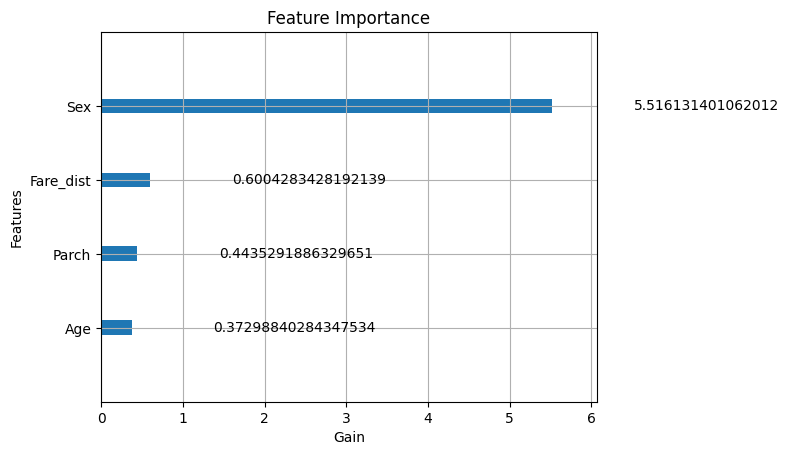

In [65]:
# Plot feature importance with custom parameters
xgb.plot_importance(xgb_final, max_num_features=10, importance_type='gain', xlabel='Gain', title='Feature Importance')
plt.show()

## Use model for prection

In [49]:
# See the test set
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [50]:
# Select corresponding features and see the empty values on the dataset
test = test[['PassengerId', 'Sex', 'Age', 'Parch', 'Fare']]
test.isna().any()

PassengerId    False
Sex            False
Age             True
Parch          False
Fare            True
dtype: bool

In [51]:
# Change empty age and fare values with median
test.loc[test['Fare'].isna(), 'Fare'] = test['Fare'].mean()
test.loc[test['Age'].isna(), 'Age'] = test['Age'].mean()

In [52]:
# See is there any empty values again
test.isna().any()

PassengerId    False
Sex            False
Age            False
Parch          False
Fare           False
dtype: bool

In [53]:
# Group the fare with same thresholds as done with the train set
very_high_fare = test['Fare'].values >= test['Fare'].quantile(0.9)
high_fare = (test['Fare'].values >= test['Fare'].quantile(0.6)) & (test['Fare'].values < test['Fare'].quantile(0.9))
medium_fare = (test['Fare'].values >= test['Fare'].quantile(0.2)) & (test['Fare'].values < test['Fare'].quantile(0.6))
low_fare = test['Fare'].values < test['Fare'].quantile(0.2)
test['Fare_dist'] = np.where(very_high_fare, 3,
                               np.where(high_fare, 2,
                                        np.where(medium_fare, 1,
                                                np.where(low_fare, 0, np.nan))))

In [54]:
# Change string features to numeric for heatmap
# male --> 1, female --> 0
test['Sex'] = np.where(test['Sex'] == 'male', 1,
                               np.where(test['Sex'] == 'female', 0, np.nan))

In [55]:
# See the test set
test.head()

,PassengerId,Sex,Age,Parch,Fare,Fare_dist
0,892,1.0,34.5,0,7.8292,1.0
1,893,0.0,47.0,0,7.0000,0.0
2,894,1.0,62.0,0,9.6875,1.0
3,895,1.0,27.0,0,8.6625,1.0
4,896,0.0,22.0,1,12.2875,1.0


In [56]:
# Change the sex and fare_dist columns data type to match with the train data
test[['Sex', 'Fare_dist']] = test[['Sex', 'Fare_dist']].astype(int)

In [57]:
# See the final test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Sex          418 non-null    int32  
 2   Age          418 non-null    float64
 3   Parch        418 non-null    int64  
 4   Fare         418 non-null    float64
 5   Fare_dist    418 non-null    int32  
dtypes: float64(2), int32(2), int64(2)
memory usage: 16.5 KB


In [58]:
# Make predictions
X = test[['Sex', 'Age', 'Parch', 'Fare_dist']]
predictions = xgb_final.predict(X)

In [59]:
# Prepare the result csv
result = pd.DataFrame()
result['PassengerId'] = test['PassengerId']
result['Survived'] = predictions

In [62]:
# Get the result csv
result.to_csv('results/titanic_prediction_3-1-24.csv', index=False)